In [1]:
!pip install --upgrade pip
!pip install matplotlib==3.0.3

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.
  Using cached pip-20.3.4-py2.py3-none-any.whl (1.5 MB)
  Using cached pip-20.3.3-py2.py3-none-any.whl (1.5 MB)
DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.


In [2]:
import os
import sys
import glob
import pickle
import random

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import policy_evaluation

sys.path.append('../common/')
import data_io_utils
import paths
import utils
import constants
import plot_style_utils


import A003_common

%reload_ext autoreload
%autoreload 2

## First generate dataset summary figures

In [3]:
data_io_utils.sync_s3_path_to_local(paths.SARKISYAN_SPLIT_2_FILE, is_single_file=True)
data_io_utils.sync_s3_path_to_local(paths.SYNTHETIC_NEIGH_SPLIT_2_FILE, is_single_file=True)
data_io_utils.sync_s3_path_to_local(paths.FP_HOMOLOGS_GEN_SPLIT_2_FILE, is_single_file=True)

# Auxilliary files 
data_io_utils.sync_s3_path_to_local(paths.SYNTHETIC_NEIGH_PARENTS_INFO_FILE, is_single_file=True)

In [4]:
sark_df = pd.read_csv(paths.SARKISYAN_SPLIT_2_FILE)

"Simplify" synthetic neighborhoods and FP homologs datasets

In [5]:
sn_df = pd.read_csv(paths.SYNTHETIC_NEIGH_SPLIT_2_FILE)
fp_df = pd.read_csv(paths.FP_HOMOLOGS_GEN_SPLIT_2_FILE)

fused_df = A003_common.generate_simplified_and_fused_gen_set(sn_df, fp_df)

FP homolog parents contained in gen set: 3


In [6]:
simple_sn_df = fused_df[fused_df['gen_set'] == 'simple_syn_neigh']
simple_fp_df = fused_df[fused_df['gen_set'] == 'simple_fp_homologs']
simple_fp_df['quantitative_function'] = (
    simple_fp_df['quantitative_function'] - np.min(simple_fp_df['quantitative_function']))

display(simple_sn_df.head())
display(simple_fp_df.head())

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,seq,quantitative_function,gen_set
0,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLCF...,1.448735e-01,simple_syn_neigh
1,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLEF...,1.448735e-01,simple_syn_neigh
2,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLEF...,1.448735e-01,simple_syn_neigh
3,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLEF...,2.007325e-07,simple_syn_neigh
4,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLEF...,2.007325e-07,simple_syn_neigh


,seq,quantitative_function,gen_set
16316,MSKGEELFTGVVPILVELDGDVNDHKFSVSGEGEGDATYGKLTLKF...,0.191779,simple_fp_homologs
16317,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.202580,simple_fp_homologs
16318,MSKGEELFTGVVPILVELDGDVNGRKFSVRGEGVGDATYGKLTLKF...,0.185254,simple_fp_homologs
16319,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLNL...,0.193319,simple_fp_homologs
16320,MRKGEELFTGVVPILVELDGDVNGHRFSVSGEGEGDATNGKLTLKF...,0.179590,simple_fp_homologs


## Plot

Basic set up

In [7]:
plot_style_utils.set_pub_plot_context()

def cwhist(ax, data, drange, nbins=30, color='k'):
    hvals, bins = np.histogram(data, bins=nbins, range=drange, normed=True)
    bc = (bins[:-1] + bins[1:])/2
    ax.bar(bc, hvals, width=np.diff(drange)[0]/nbins, color=color)

In [8]:
def plot_dataset_summary(df):

    np.random.seed(1)
    random.seed(1)

    nsub = 200
    pidx = np.random.permutation(df.shape[0])[:nsub]
    iu = np.triu_indices(nsub, k=1)

    ld_av = utils.levenshtein_distance_matrix([constants.AVGFP_AA_SEQ], list(df['seq'])).reshape(-1)
    ld_pw = utils.levenshtein_distance_matrix(list(df['seq'].iloc[pidx]))
    ld_pw = ld_pw[iu]
    
    fig = plt.figure(figsize=(8,4))
    gs = fig.add_gridspec(2, 2)
    plt.rcParams.update({'font.size': 22})

    nmut_range = [0, 64]
    qfunc_range = [0, 2.95]

    ax1 = fig.add_subplot(gs[:,0])
    plot_style_utils.prettify_ax(ax1)
    cwhist(ax1, df['quantitative_function'], qfunc_range, nbins=20)
    ax1.set_yscale('log')
    ax1.set_yticks([])
    ax1.set_xlim(qfunc_range)
    ax1.set_xlabel('Log rel. fluorescence', fontsize=22)
    ax1.axvline(1, color='r', linestyle='--', zorder=-1)

    ax2 = fig.add_subplot(gs[0,1])
    plot_style_utils.prettify_ax(ax2)
    cwhist(ax2, ld_av, nmut_range, nbins=20)
    ax2.set_xlim(nmut_range)
    ax2.set_yticks([])
    ax2.set_xticks([])

    ax3 = fig.add_subplot(gs[1,1])
    plot_style_utils.prettify_ax(ax3)
    cwhist(ax3, ld_pw, nmut_range, nbins=20)
    ax3.set_yticks([])
    ax3.set_xlim(nmut_range)
    ax3.set_xlabel('Num. mutations', fontsize=22)
    
   

    plt.show()
    
    return fig

In [9]:
print(sark_df.shape)
print(simple_sn_df.shape)
print(simple_fp_df.shape)

(17238, 2)
(16316, 3)
(2916, 3)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


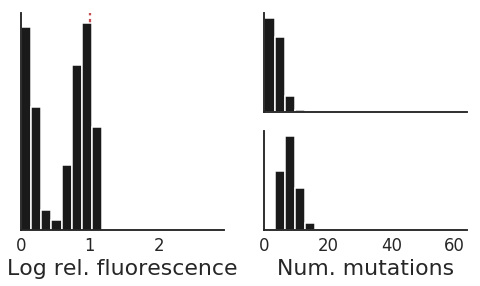

In [10]:
fig = plot_dataset_summary(sark_df)
plot_style_utils.save_for_pub(fig, path="figures/sarkisyan_summary", dpi=300)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.


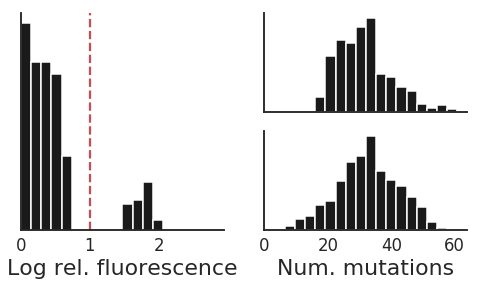

In [11]:
fig = plot_dataset_summary(simple_sn_df)
plot_style_utils.save_for_pub(fig, path="figures/simple_syn_neigh", dpi=300)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.


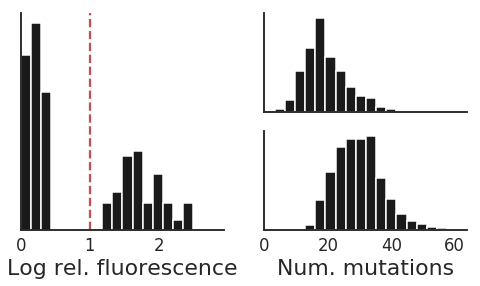

In [12]:
fig = plot_dataset_summary(simple_fp_df)
plot_style_utils.save_for_pub(fig, path="figures/simple_fp_homologs", dpi=300)